In [2]:
from makiflow.layers import *
from makiflow.models.segmentation.segmentator import Segmentator
from makiflow.save_recover import Builder
from makiflow.trainers import SegmentatorTrainer
from makiflow.metrics import categorical_dice_coeff, confusion_mat
import makiflow as mf

import tensorflow as tf
import numpy as np
import glob
import cv2
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter

W0127 14:43:28.904020 140107585378048 deprecation_wrapper.py:119] From /home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/base/maki_entities.py:143: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [3]:
mf.set_main_gpu(0)

In [ ]:
import tensorflow.contrib.tensorrt.

In [5]:
def load_data(path_to_data='/raid/rustam/med_data/all_data'):
    Xtrain = []
    Ytrain = []

    masks = glob.glob(f'{path_to_data}/masks/*.bmp')
    i = 0
    masks.sort()
    for mask_name in tqdm(masks):
        img = cv2.imread(mask_name.replace('masks', 'images'))
        mask = cv2.imread(mask_name)
        i += 1
        
        img = cv2.resize(img, (1024, 1024), interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
        
        Xtrain.append(img)
        Ytrain.append(mask[:, :, 0])
        
    return Xtrain, Ytrain

In [17]:
class ImageCutter:

    @staticmethod
    def image_and_mask_cutter(
        images, masks, window_h, window_w, step_x, step_y, classes_to_get,
        use_all_px=True
    ):
        """
        Crops `images` and `masks` using sliding window with resize.
        Parameters
        ----------
        images : list
            List of input images.
        masks : list
            List of input masks.
        window_h : int
            Output image height.
        window_w : int
            Output image width.
        step_x : int
            Sliding window step by OX.
        step_y : int
            Sliding window step by OX.
        scale_factor : float
            Scale factor, must be in range (0, 1). After each 'sliding window step' the original images
            are resized to (previous_width * scale_factor, previous_height * scale_factor).
        postprocessing : func
            Post processing function, using on cropped image (may be function what calculate num positives pixels).
        use_all_px : bool
            If True, all pixels of image would be in output lists.

        Returns
        -------
        Three list:
            1. cropped images
            2. cropped masks
            3. additional list (result of post processing)
        """
        assert (len(images) > 0)
        assert (len(images) == len(masks))
        assert (window_h > 0 and window_w > 0 and step_x > 0 and step_y > 0)

        cropped_images = []
        cropped_masks = []
        additional_list = []
        dx = 0
        dy = 0

        for index, (img, mask) in enumerate(zip(images, masks)):
            print(index)
            assert (img.shape[:2] == mask.shape[:2])
            current_height, current_width = img.shape[:2]


            for dy in range(int((current_height - window_h) / step_y)):
                for dx in range(int((current_width - window_w) / step_x)):
                    crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                        img,
                        mask,
                        dy * step_y, dy * step_y + window_h, dx * step_x, dx * step_x + window_w)
                    if ImageCutter.has_class(crop_mask, classes_to_get):
                        cropped_images.append(crop_img)
                        cropped_masks.append(crop_mask)

            if use_all_px:
                overlap_y = dy * step_y + window_h != current_height
                overlap_x = dx * step_x + window_w != current_width
                if overlap_y:
                    for dx in range(int((current_width - window_w) / step_x)):
                        crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                            img,
                            mask,
                            current_height - window_h, current_height, dx * step_x, dx * step_x + window_w)
                        if ImageCutter.has_class(crop_mask, classes_to_get):
                            cropped_images.append(crop_img)
                            cropped_masks.append(crop_mask)

                if overlap_x:
                    for dy in range(int((current_height - window_h) / step_y)):
                        crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                            img,
                            mask,
                            dy * step_y, dy * step_y + window_h, current_width - window_w, current_width)
                        if ImageCutter.has_class(crop_mask, classes_to_get):
                            cropped_images.append(crop_img)
                            cropped_masks.append(crop_mask)

                if overlap_x and overlap_y:
                    crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                        img,
                        mask,
                        current_height - window_h, current_height, current_width - window_w, current_width)
                    if ImageCutter.has_class(crop_mask, classes_to_get):
                        cropped_images.append(crop_img)
                        cropped_masks.append(crop_mask)

        return cropped_images, cropped_masks, additional_list

    @staticmethod
    def crop_img_and_mask(img, mask, up, down, left, right):
        crop_img = img[up: down, left: right]
        crop_mask = mask[up: down, left: right]
        return crop_img, crop_mask
    
    @staticmethod
    def has_class(mask, needed):
        actual = np.unique(mask)
        for need in needed:
            if need in actual:
                return True
        return False

In [18]:
def get_test_data():
    images, labels = load_data()
    imgs, lbls = [], []
    for i, (img, lbl) in enumerate(zip(images, labels)):
        if i in [2, 24, 41, 85, 75, 6, 7]:
            imgs += [img]
            lbls += [lbl]
            
#     cropped_images1, cropped_masks1, _ = ImageCutter.image_and_mask_cutter(imgs, lbls,
#         window_h=256, window_w=256, step_x=50, step_y=50, classes_to_get=[40, 70, 80])
    
#     cropped_images2, cropped_masks2, _ = ImageCutter.image_and_mask_cutter(
#         imgs, lbls, window_h=256, window_w=256, step_x=40, step_y=40, classes_to_get=[70])
    
#     cropped_images3, cropped_masks3, _ = ImageCutter.image_and_mask_cutter(
#         imgs, lbls, window_h=256, window_w=256, step_x=60, step_y=60, classes_to_get=[60])
    
#     cropped_images4, cropped_masks4, _ = ImageCutter.image_and_mask_cutter(
#         imgs, lbls, window_h=256, window_w=256, step_x=60, step_y=60, classes_to_get=[10])
        
#     cropped_images = cropped_images1 + cropped_images2 + cropped_images3 + cropped_images4 + cropped_images1[:8]
#     cropped_masks = cropped_masks1 + cropped_masks2 + cropped_masks3 + cropped_masks4 + cropped_masks1[:8]
#     print(len(cropped_images))
#     assert(len(cropped_images) % 8 == 0)
    return imgs, lbls

In [6]:
def normalize_data(Xtrain, Ytrain, Xtest, Ytest):
    Xtrain = np.asarray(Xtrain).astype(np.float32) / 255
    Xtrain = [i for i in Xtrain]
    Ytrain = np.asarray(Ytrain).astype(np.uint8) // 10
    Ytrain = [i for i in Ytrain]
    
    Xtest = np.asarray(Xtest, dtype=np.float32) / 255
    Xtest = [i for i in Xtest]
    Ytest = np.asarray(Ytest, dtype=np.uint8) // 10
    Ytest = [i for i in Ytest]
    return Xtrain, Ytrain, Xtest, Ytest

In [7]:
images, labels = load_data()

100%|██████████| 115/115 [00:00<00:00, 154.62it/s]


In [5]:
Xtest, Ytest = get_test_data()

NameError: name 'get_test_data' is not defined

In [8]:
images, labels, Xtest, Ytest = normalize_data(images, labels, [], [])

In [9]:
model = Builder.segmentator_from_json('/home/rustam/EyePit/Models/x65/xception_unet_v13.json', batch_size=1)

W0127 14:43:43.594877 140107585378048 deprecation_wrapper.py:119] From /home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/layers/untrainable_layers.py:24: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0127 14:43:48.795364 140107585378048 deprecation_wrapper.py:119] From /home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/layers/untrainable_layers.py:565: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.



Model is restored!


In [10]:
model.set_session(tf.Session())

W0127 14:43:50.421552 140107585378048 deprecation_wrapper.py:119] From /home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/base/maki_entities.py:152: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



In [11]:
model.load_weights('/home/rustam/EyePit/PaperGradientBalancing/Test#3_x-65_CrossValidation3Batches(Artem)_BalancedData/exp_cv1/x-65/MakiSegmentator_gamma=2_opt_name=adam1_bsz=8/epoch_19/weights.ckpt')

W0127 14:43:55.487048 140107585378048 deprecation_wrapper.py:119] From /home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/base/maki_entities.py:173: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0127 14:43:56.185401 140107585378048 deprecation.py:323] From /home/rustam/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Weights are loaded.


In [14]:
batch_sz = 1

In [22]:
n_batches = len(images) // batch_sz
labels = []
predictions = []
for i in range(n_batches):
    predictions += [model.predict(images[i * batch_sz: (i+1) * batch_sz])]

In [23]:
predictions_last = np.vstack(predictions)
labels = np.asarray(labels)

In [22]:
predictions_10 = np.vstack(predictions)
labels = np.asarray(labels)

In [89]:
predictions_5 = np.vstack(predictions)
labels = np.asarray(labels)

In [63]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#FFC618", "#fa18ff", "#9bff18", "#18fffa"]
cmap=sns.color_palette("Paired", 10)

In [28]:
%matplotlib inline

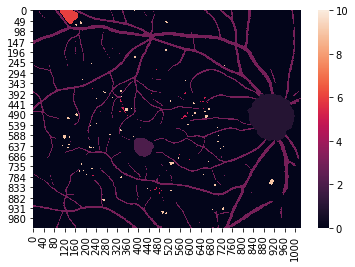

In [31]:
sns.heatmap(predictions_last[0].argmax(axis=2), vmin=0, vmax=10)

In [27]:
predictions_last.shape

(115, 1024, 1024, 10)

In [16]:
img_num = 0
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
sns.heatmap(predictions_last[img_num].argmax(axis=2) * 10, vmin=0, vmax=10, ax=axs[0], cbar=False)
sns.heatmap(Ytest[img_num],vmin=0, vmax=10, ax=axs[1], cbar=False)
# sns.heatmap(predictions_10[img_num].argmax(axis=2),vmin=0, vmax=10, ax=axs[1][0], cbar=False)
plt.imshow(Xtest[img_num])
fig.savefig('all in one.png')

IndexError: list index out of range

In [43]:
rare_dict = {i : 0 for i in range(10)}
for i, lbl in enumerate(Ytest):
    u = np.unique(lbl)
    for u_num in u:
        rare_dict[u_num] += 1
rare_dict

{0: 2015,
 1: 445,
 2: 116,
 3: 2016,
 4: 468,
 5: 564,
 6: 157,
 7: 67,
 8: 913,
 9: 1287}

In [16]:
np.unique(Ytest[1200])

IndexError: list index out of range

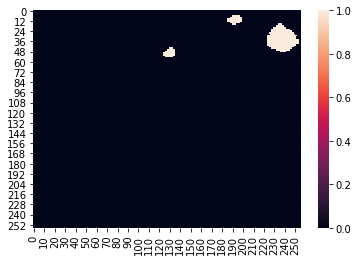

In [81]:
sns.heatmap(Ytest[1200] == 9)

NameError: name 'predictions_10' is not defined

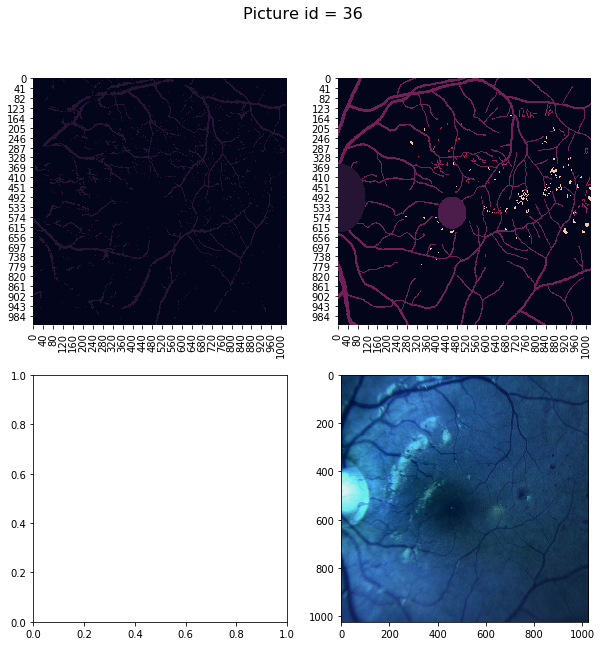

In [17]:
for img_num, img_id in enumerate([36, 37, 50, 83, 78, 17, 67]):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    fig.suptitle(f'Picture id = {img_id}', fontsize=16)
    sns.heatmap(predictions_last[img_num].argmax(axis=2), vmin=0, vmax=10, ax=axs[0][0], cbar=False)
    sns.heatmap(Ytest[img_num],vmin=0, vmax=10, ax=axs[0][1], cbar=False)
    plt.imshow(Xtest[img_num])
    sns.heatmap(predictions_10[img_num].argmax(axis=2), vmin=0, vmax=10, ax=axs[1][0], cbar=False)
#     sns.heatmap(Ytest[img_num],vmin=0, vmax=10, ax=axs[1][1], cbar=False)
    plt.imshow(Xtest[img_num])
    fig.savefig(f'{img_num}.png')

### TEST

In [104]:
dd

NameError: name 'path_to_data' is not defined

In [13]:
 _, _, Xtest, Ytest = normalize_data([], [], images, labels)

In [14]:
labels = Ytest[87:88]
predictions = [model.predict(Xtest[87:88])]

In [15]:
predictions[0][0].argmax(axis=2).shape

(1024, 1024)

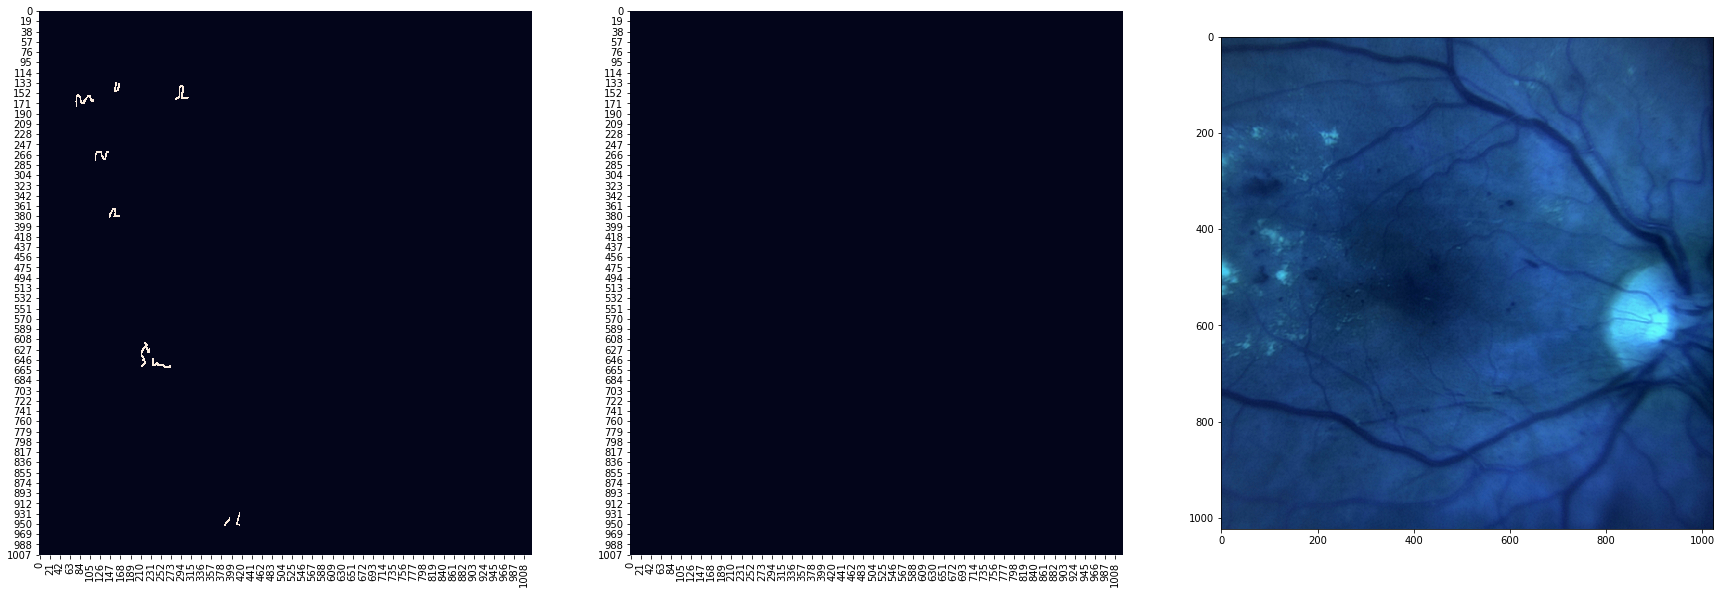

In [23]:
img_num = 88
labels = Ytest[img_num:img_num + 1]
predictions = [model.predict(Xtest[img_num:img_num + 1])]
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30,10))
sns.heatmap(Ytest[img_num] == 4,vmin=0, vmax=1, ax=axs[0], cbar=False)
sns.heatmap(predictions[0][0].argmax(axis=2),vmin=0, vmax=10, ax=axs[1], cbar=False)
plt.imshow(Xtest[img_num])

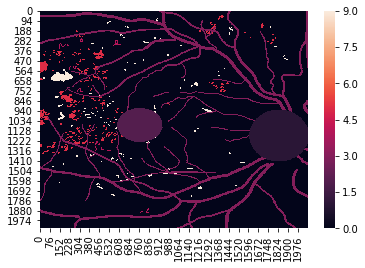

In [16]:
img_num = 88
sns.heatmap(Ytest[img_num])

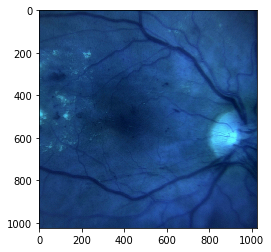

In [20]:
plt.imshow(Xtest[img_num])

In [117]:

predictions[0][0][..., 7].shape

(1024, 1024)

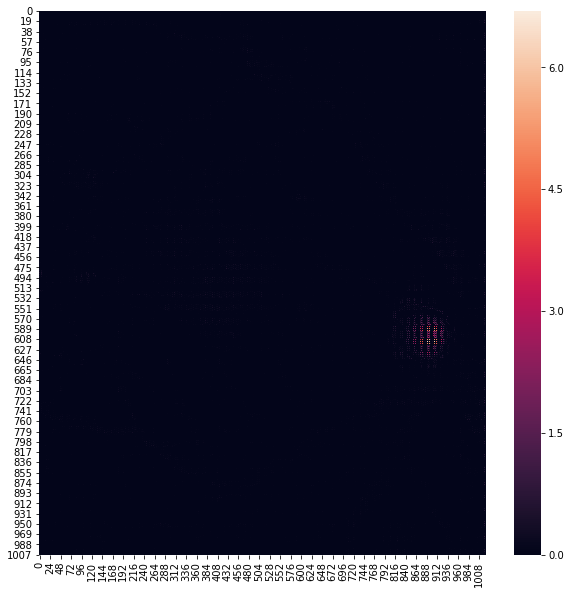

In [22]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.heatmap(predictions[0][0][..., 1], ax=axs)

In [93]:
x = np.linspace(0.2, 0.9, 100)
y1 = [((1-p)**(1/p))/p for p in x]
y2 = [1/p for p in x]
f1 = [x, y1]
f2 = [x, y2]

In [ ]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(x, y1, label='')
ax2.plot(x, y2)

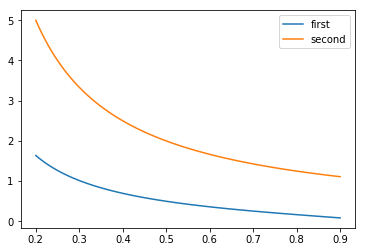

In [97]:
plt.plot(x, y1, label='first')
plt.plot(x, y2, label='second')
plt.legend()